<a href="https://colab.research.google.com/github/ToukaNour30/VGG-16/blob/main/vgg_batch_size_32_VGG_trial1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib scikit-learn

In [ ]:
!pip install kaggle tensorflow numpy matplotlib scikit-learn

In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"<toukanour >", "key":"<your_kaggle_api_key>"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d rm1000/brain-tumor-mri-scans


Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 99% 234M/236M [00:11<00:00, 25.2MB/s]
100% 236M/236M [00:11<00:00, 21.7MB/s]


In [ ]:
import zipfile
zip_path = "/content/brain-tumor-mri-scans.zip"  # Update the path if different
extract_path = "/content/brain-tumor-mri-scans"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")

Dataset extracted!


In [ ]:
import os

# Path to the extracted dataset
dataset_path = "/content/brain-tumor-mri-scans"

# Verify the contents of the dataset
print("Available files and folders:")
print(os.listdir(dataset_path))


Available files and folders:
['meningioma', 'healthy', 'glioma', 'pituitary']


In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import numpy as np


In [ ]:
dataset_path = "/content/brain-tumor-mri-scans"  # Update with your dataset path
categories = ['healthy', 'glioma', 'meningioma', 'pituitary']

# Parameters
img_size = (224, 224)  # Input size for VGG
batch_size = 32


# Function to get dataset
def get_dataset(dataset_path, categories):
    image_paths = []
    labels = []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        label = categories.index(category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            image_paths.append(img_path)
            labels.append(label)

    return image_paths, labels

# Load the image paths and labels
image_paths, labels = get_dataset(dataset_path, categories)

# Split into train and test (70% for training, 30% for testing)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# Print shapes of train and test datasets (number of batches)
print(f"Train dataset batches: {len(train_paths) // batch_size}")
print(f"Test dataset batches: {len(test_paths) // batch_size}")

Train dataset batches: 153
Test dataset batches: 65


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

# Resizing and preprocessing images for VGG
def preprocess_image(img_path):
    # Load the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming images are in JPEG format
    img = tf.image.resize(img, (224, 224))  # Resize to (224, 224)
    img = preprocess_input(img)  # Preprocess the image for VGG
    return img

# Apply preprocessing to the datasets
def create_vgg_dataset(image_paths, labels, batch_size=32):
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map function to load, resize, and preprocess the images
    dataset = dataset.map(lambda img_path, label: (preprocess_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Convert labels to one-hot encoding for VGG (assuming 4 classes in your dataset)
train_labels_one_hot = to_categorical(train_labels, num_classes=4)  # Change `num_classes=4` if necessary
test_labels_one_hot = to_categorical(test_labels, num_classes=4)

# Create the VGG-compatible datasets
train_ds_vgg = create_vgg_dataset(train_paths, train_labels_one_hot)
test_ds_vgg = create_vgg_dataset(test_paths, test_labels_one_hot)

# Print shapes of train and test datasets
print(f"Train dataset batches: {len(train_paths) // 32}")
print(f"Test dataset batches: {len(test_paths) // 32}")


Train dataset batches: 153
Test dataset batches: 65


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
fine_tune = 0
if fine_tune > 0:
  for layer in base_model.layers[:-fine_tune]:
    layer.trainable = False
else:
  for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Print shapes of the batches
for images, labels in train_ds_vgg.take(1):
    print(f"Train batch images shape: {images.shape}")
    print(f"Train batch labels shape: {labels.shape}")

for images, labels in test_ds_vgg.take(1):
    print(f"Test batch images shape: {images.shape}")
    print(f"Test batch labels shape: {labels.shape}")


Train batch images shape: (32, 224, 224, 3)
Train batch labels shape: (32, 4)
Test batch images shape: (32, 224, 224, 3)
Test batch labels shape: (32, 4)


In [ ]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(4, activation='softmax')
])

## **cross validation traing (K-cross validation)**

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

# Parameters
k = 3  # Number of folds for cross-validation
epochs = 20  # Number of epochs
batch_size = 32  # Batch size for training

# Convert train_paths and train_labels to numpy arrays for compatibility with KFold
train_paths_array = np.array(train_paths)
train_labels_array = np.array(train_labels_one_hot)

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the results for each fold
fold_accuracies = []
fold_losses = []

# Loop over the folds for cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(train_paths_array)):
    print(f"Training fold {fold + 1}/{k}...")

    # Split the data into training and validation sets for this fold
    fold_train_paths = train_paths_array[train_index]
    fold_val_paths = train_paths_array[val_index]
    fold_train_labels = train_labels_array[train_index]
    fold_val_labels = train_labels_array[val_index]

    # Create the datasets for this fold
    train_ds_fold = create_vgg_dataset(fold_train_paths, fold_train_labels, batch_size)
    val_ds_fold = create_vgg_dataset(fold_val_paths, fold_val_labels, batch_size)

    # Create a new model for each fold
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    # Compile the model
    new_learning_rate = 0.0001  # Adjust as needed

    # Compile the model with the new learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_ds_fold, epochs=epochs, validation_data=val_ds_fold
    )

    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate(val_ds_fold)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_acc)

    print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Calculate the average performance across all folds
avg_loss = np.mean(fold_losses)
avg_acc = np.mean(fold_accuracies)

print(f"Average Validation Loss: {avg_loss:.4f}")
print(f"Average Validation Accuracy: {avg_acc:.4f}")


Training fold 1/3...
Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - accuracy: 0.6160 - loss: 1.6813 - val_accuracy: 0.8737 - val_loss: 0.4235
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.9197 - loss: 0.2222 - val_accuracy: 0.9030 - val_loss: 0.3609
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.9813 - loss: 0.0748 - val_accuracy: 0.9115 - val_loss: 0.3330
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 214ms/step - accuracy: 0.9953 - loss: 0.0300 - val_accuracy: 0.9170 - val_loss: 0.3310
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.9986 - loss: 0.0145 - val_accuracy: 0.9237 - val_loss: 0.3290
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9997 - loss: 0.0083 - val_accuracy: 0.9250 - val_loss: 0.3354
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.9997 - loss: 0.0054 - val_accuracy: 0.9280 - val_loss: 0.3372
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 216ms/step - accur

# es+epochs

In [ ]:

def split_dataset(dataset, validation_split=0.2):
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

# Split the datasets into train and validation datasets
train_ds_split, val_ds_split = split_dataset(train_ds_vgg, validation_split=0.2)

# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
history = model.fit(
    train_ds_split,  # Train dataset
    epochs=20,
    validation_data=val_ds_split,  # Validation dataset
    callbacks=[es]
)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 47s 362ms/step - accuracy: 0.7915 - loss: 1.3811 - val_accuracy: 0.8977 - val_loss: 0.3470
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.9410 - loss: 0.2080 - val_accuracy: 0.9430 - val_loss: 0.2158
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 255ms/step - accuracy: 0.9622 - loss: 0.1154 - val_accuracy: 0.9314 - val_loss: 0.2992
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.9607 - loss: 0.1421 - val_accuracy: 0.9262 - val_loss: 0.3959
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - accuracy: 0.9715 - loss: 0.1082 - val_accuracy: 0.9399 - val_loss: 0.2631


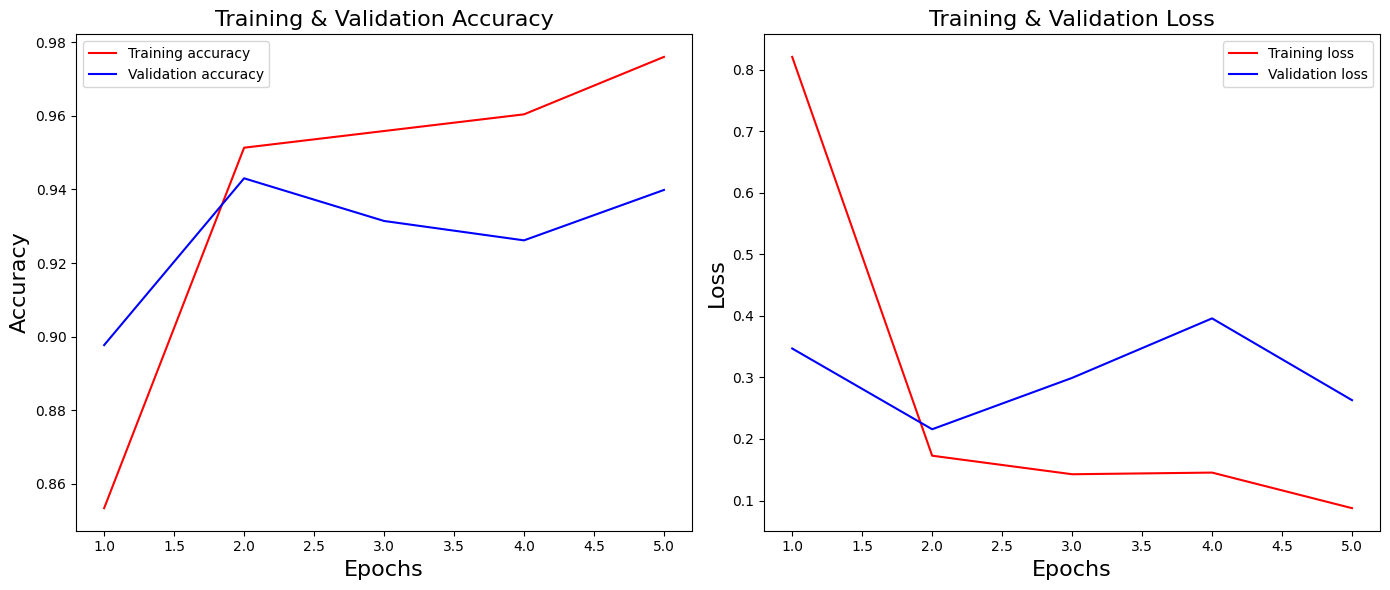

In [ ]:
if history and hasattr(history, 'history'):
    # Extract the history dictionary
    history_dict = history.history

    # Ensure the metrics exist in the history dictionary
    loss_values = history_dict.get('loss', [])
    val_loss_values = history_dict.get('val_loss', [])
    accuracy = history_dict.get('accuracy', [])
    val_accuracy = history_dict.get('val_accuracy', [])

    # Check if metrics are available
    if not loss_values or not val_loss_values or not accuracy or not val_accuracy:
        print("Training history does not contain all required metrics.")
    else:
        # Define the range of epochs
        epochs = range(1, len(loss_values) + 1)

        # Create subplots for accuracy and loss
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot Training & Validation Accuracy
        ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
        ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        ax[0].set_title('Training & Validation Accuracy', fontsize=16)
        ax[0].set_xlabel('Epochs', fontsize=16)
        ax[0].set_ylabel('Accuracy', fontsize=16)
        ax[0].legend()

        # Plot Training & Validation Loss
        ax[1].plot(epochs, loss_values, 'r', label='Training loss')
        ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
        ax[1].set_title('Training & Validation Loss', fontsize=16)
        ax[1].set_xlabel('Epochs', fontsize=16)
        ax[1].set_ylabel('Loss', fontsize=16)
        ax[1].legend()

        # Display the plots
        plt.tight_layout()
        plt.show()
else:
    print("No training history found or history object is invalid.")

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step
Test Accuracy: 92.26%
Precision: 0.93
Recall: 0.92
F1 Score: 0.92


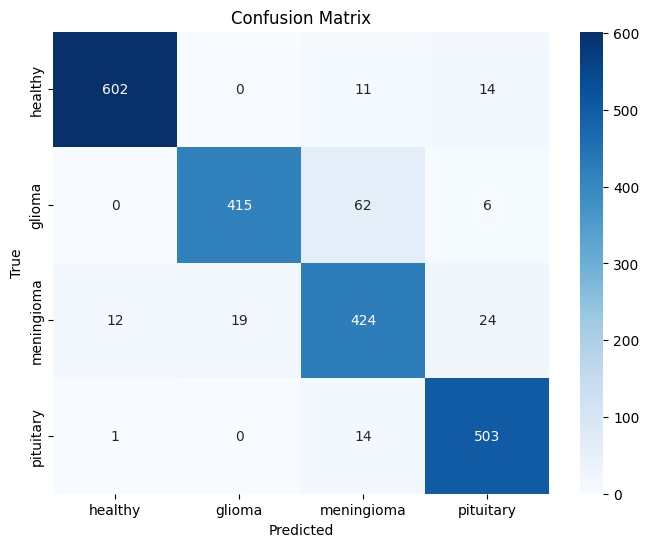

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Evaluate the model on the test dataset
test_predictions = model.predict(test_ds_vgg)
test_labels = np.array(test_labels_one_hot)

# Convert predictions from one-hot to label (argmax to get class index)
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print the metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 50)                  │       1,254,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,481,352 (70.50 MB)

 Trainable params: 1,255,554 (4.79 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,511,110 (9.58 MB)

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9237 - loss: 0.4445
Test Loss: 0.42404282093048096
Test Accuracy: 0.9226388335227966
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step
Predictions (first sample): 3
True label (first sample): 2


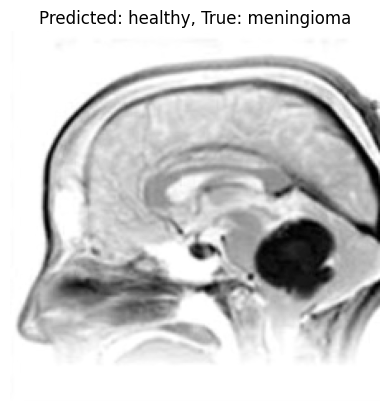

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds_vgg)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Make predictions on the test set
# Iterate over the test dataset and make predictions
predictions = model.predict(test_ds_vgg)

# Get the true labels (in case you need to print them or evaluate performance)
test_labels = np.array(test_labels_one_hot)

# Convert predictions from one-hot to class labels
predictions_classes = np.argmax(predictions, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1)

# Print predictions and the first test image
print("Predictions (first sample):", predictions_classes[0])
print("True label (first sample):", test_labels_classes[0])

# You need to extract one image from the dataset to display it
# Display the first image from the dataset, using the actual image from the dataset (after preprocessing)
# Display the first image from the dataset
for images, labels in test_ds_vgg.take(1):
    # Convert the image to grayscale by averaging the RGB channels
    grayscale_image = tf.image.rgb_to_grayscale(images[0])

    # Display the grayscale image
    plt.imshow(grayscale_image.numpy().squeeze(), cmap=plt.cm.binary)  # Use binary colormap for black and white
    plt.title(f"Predicted: {categories[np.argmax(predictions_classes[0])]}, True: {categories[test_labels_classes[0]]}")
    plt.axis('off')  # Hide axis for better visualization
    plt.show()